# This notebook is a demonstration of running the combined peak ranging and peak ion identification ML models

Ryan Jacobs, based on original code from Jingrui Wei

Last updated: 4/16/25 by Ryan Jacobs


In [1]:
# Link Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone repo

!git clone https://github.com/uw-cmg/peak_detection

Cloning into 'peak_detection'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 532 (delta 39), reused 23 (delta 8), pack-reused 449 (from 1)
Receiving objects: 100% (532/532), 56.21 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (285/285), done.


In [3]:
# Install dependencies. Annoyingly takes about 5 minutes.

!pip install -r "peak_detection/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of lmfit to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [1]:
# For Colab, move repo directories so imports work

import shutil
shutil.move('peak_detection', 'peak_detection_repo')
shutil.move('peak_detection_repo/peak_detection', '.')

'./peak_detection'

In [2]:
# Import needed packages

import apav
import os
import peak_detection
from peak_detection.RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder
import yaml
from pathlib import Path
import torch.nn.functional as F

In [3]:
# Function definitions to do model predictions and visualization

def map01(ar):
    return (ar-ar.min()) / (ar.max()-ar.min())

def load_apt(apt_file):
    '''

    '''
    # Load the .apt file and get histogram
    d = apav.load_apt(apt_file)
    x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False,)
    spectrum_log = torch.tensor(map01(np.log(spectrum+1)), dtype=torch.float32)
    return spectrum, spectrum_log

def get_label_encoder():
    '''

    '''

    CHEMICAL_ELEMENTS = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
                         'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
                         'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',
                         'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                         'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
                         'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir',
                         'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

    le = LabelEncoder()
    le.fit(CHEMICAL_ELEMENTS)
    return le

def predict_elements(model, spectrum, label_encoder, device):
    '''

    '''
    model.eval()
    with torch.no_grad():
        spectrum = torch.FloatTensor(spectrum).unsqueeze(0).to(device)
        outputs = model(spectrum, lengths = [spectrum.shape[1]])

        probabilities = F.softmax(outputs, dim=2)
        predictions = torch.argmax(outputs, dim=2)

        # Convert numerical predictions to element names
        element_predictions = label_encoder.inverse_transform(predictions.cpu().numpy().ravel())
        confidence_scores = torch.max(probabilities, dim=2)[0].cpu().numpy().ravel()

        return element_predictions, confidence_scores

def plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000):
    '''
    plot_max : # in 0.01 Da
    '''
    plt.clf()
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # set the zoom in m/c range
    bin_width = 0.01
    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] >plot_min)]

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Plot the spectrum
    x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

    ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    for start, end in peak_pred_:
        ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
    for start, end in peak_pred_:
        ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
        ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)

    # Set labels and title
    ax.set_xlabel('Mass to charge ratio (Da)')
    ax.set_ylabel('Intensity in log scale normalized (counts)')

    ax.set_xlim(-2, 0.01*plot_max)

    # Add the predicted ions and their confidences
    for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
        if peak_start < plot_max:
            y_rand = np.random.uniform(low=0.5, high=1.0)

            ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    plt.legend()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def predict_peak_ranges(apt_file, conf=0.02, iou=0.01, max_det=2000):
    '''

    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # Load in the RangingNN model and do the peak detection
    cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
    cfg = yaml.safe_load(Path(cfg).read_text())

    cfg['iou'] = iou
    cfg['conf'] = conf
    cfg['max_det'] = max_det

    modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights/best.pt') # loading the default trained-model in the package
    predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = 'test_results', cfg = cfg)
    result = predictor()[0]
    peak_range_pred = result[:,:2].cpu()

    print('model predicted peaks:',peak_range_pred.shape[0])

    return peak_range_pred

def predict_peak_ions(peak_range_pred, bin_width=0.01, max_width_Da=0.5):
    '''
    Certain wide ranges due to the tail leads to over-high indensity,
    shrinking the other intensities, so set limit here
    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    profile = np.zeros_like(peak_range_pred)
    peak_range_pred = np.asarray(peak_range_pred)

    # Preprocess detected peak ranging data for IonClassifier model
    for k in range(profile.shape[0]):
        profile[k][0] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][1])+1].argmax()
        profile[k][0] = (profile[k][0] + round(peak_range_pred[k][0]))/100

        window = min(max_width_Da/bin_width, round(peak_range_pred[k][1])+1-round(peak_range_pred[k][0]))
        profile[k][1] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][0]+window)].sum()

    profile[:,1] = (profile[:,1] - profile[:,1].min() ) / (profile[:,1].max() - profile[:,1].min()) # normalize counts from one spectrum to 0-1

    # Make sure the profile is in sequential order, increasing m/c
    profile_final = profile[profile[:, 0].argsort()]

    # Run the IonClassifier model to predict the peak IDs
    model_path = os.path.join(os.path.dirname(peak_detection.__file__), 'Ionclassifier/modelweights')
    RNNmodel = torch.load(os.path.join(model_path, 'model_bestepoch.tar'), map_location='cpu')['ema']
    le = get_label_encoder()
    res, confidence = predict_elements(RNNmodel, profile_final, le, 'cpu')

    return res, confidence, profile_final


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  138.9ms inference, 5.8ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt
<ipython-input-3-34a7a04d0bf0>:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


<Figure size 640x480 with 0 Axes>

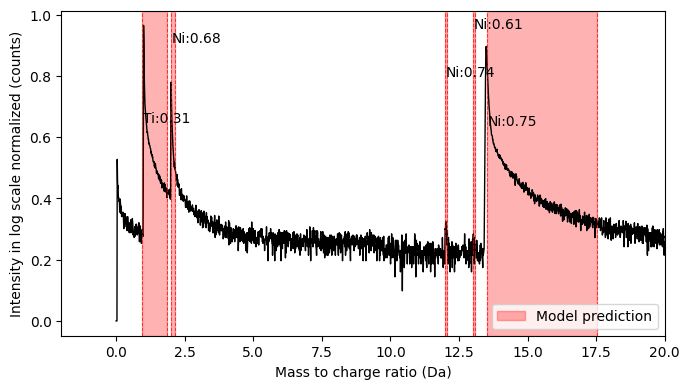

In [4]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

res, confidence, profile_final = predict_peak_ions(peak_range_pred, bin_width=0.01, max_width_Da=0.5)

plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=2000)
